In [86]:
# functions to organize data before building matrix
# -------------------------------------------------
def construct_indu_index_mapping(df):
    """
    Construct a dictionary with
    key: industry code
    value: indexes of all reports in the dataframe
    """
    industries_to_index = {}
    industries = df["ggroup"].dropna().astype(int).unique()
    industries = industries.tolist()
    quarters = (df["year"].astype("str") + " q" + df["quarter"].astype("str")).unique()
    for i in range(df.shape[0]):
        row = df.iloc[i, :]
        if math.isnan(row["ggroup"]):
            continue
        industries_to_index[int(row["ggroup"])] = industries_to_index.get(int(row["ggroup"]), set())
        industries_to_index[int(row["ggroup"])].add(i)
    return industries_to_index
def construct_quar_index_mapping(df):
    """
    Construct a dictionary with
    key: quarter
    value: indexes of all reports in the dataframe
    """
    quarters = (df["year"].astype("str") + " q" + df["quarter"].astype("str")).unique()
    quarter_to_index = {}
    for i in range(df.shape[0]):
        row = df.iloc[i, :]
        quarter = row["year"].astype("str") + " q" + row["quarter"].astype("str")
        quarter_to_index[quarter] = quarter_to_index.get(quarter, set())
        quarter_to_index[quarter].add(i)
    return quarter_to_index
def construct_analyst_index_mapping(df, all_files_dcns):
    """
    Construct a dictionary with
    key: analyst
    value: indexes of all reports in the dataframe with the given DCNs(unique identification code for the reports)
    """
    analyst_to_index = {}
    for i, (_, dcn) in enumerate(all_files_dcns):
        analyst = max(df[df["DCN"] == dcn]["Analyst"])
        if not analyst is np.nan:
            analyst_to_index[analyst] = analyst_to_index.get(analyst, []) + [i]
    return analyst_to_index
def get_all_companies(df, indexes):
    """
    Return the set of companies in the dataframe with the given indexes
    """
    raw_companies = df.iloc[list(indexes), 4].unique()
    all_companies = set()
    for item in raw_companies:
        l = item.split(",")
        for company in l:
            all_companies.add(company.strip(" ").strip("^L19"))
    return all_companies
def get_company_files(target_dcns):
    """
    Return a list of tuples that contains file paths and DCNs of all reports with the target DCNs
    """
    # directory = r".\PDFParsing\parsed_files"
    directory = r".\PDFParsing\clean_txt_flat"
    files = []
    temp = os.path.join(directory)
    list_files = os.listdir(temp)
    for item in list_files:
        l = item.split("-")
        dcn = l[-1].rstrip(".txt").rstrip("(1)")
        while dcn and not dcn[-1].isdigit():
            dcn = dcn[:-1]
        while dcn and not dcn[0].isdigit():
            dcn = dcn[1:]
        if dcn:
            dcn = int(dcn)
        else:
            continue
        if dcn in target_dcns:
            files.append((os.path.join(temp, item), dcn))
    return files


# functions to help with Shapley values
# -------------------------------------

# normalize rows in a two-dimensional matrix
def normalize_rows(x: np.ndarray):  # function to normalize rows in a two-dimensional materix
    return x / np.linalg.norm(x, ord=2, axis=1, keepdims=True)
# shapley values function
def shapley_values(loading_matrix):
    loading_matrix = normalize_rows(loading_matrix)

    no_analysts = np.shape(np.dot(loading_matrix, loading_matrix.T))[1]  # number of analysts
    list_analysts = [x for x in range(no_analysts)]
    data = pd.DataFrame(columns={'Analyst', 'InfoContribution'})

    for k in range(no_analysts):
        list_minusone = [x for x in list_analysts if x != k]  # list without the analyst
        all_sets = [x for x in ps.powerset(list_minusone) if x]

        shapley_value = []

        for coalition in all_sets:
            other_coal = loading_matrix[coalition, :].sum(axis=0)
            other_coal = other_coal / np.linalg.norm(other_coal, ord=2, axis=0, keepdims=True)

            contribution = 1 - np.dot(other_coal, loading_matrix[k, :])

            shapley_value.append(contribution)

            # print(coalition, np.dot(other_coal,loading_matrix[k,:]), contribution)

        # print(np.array(shapley_value).mean())
        data = data.append({'Analyst': k, 'InfoContribution': np.array(shapley_value).mean()}, ignore_index=True)

    return data
# get informational diversity measure
def diversity(loading_matrix):
    ld_matrix_norm = normalize_rows(loading_matrix)  # normalize all row vectors
    cosine_matrix = np.dot(ld_matrix_norm, ld_matrix_norm.T)  # compute dot products across normalized rows
    avg_similarity = cosine_matrix[np.triu_indices(np.shape(cosine_matrix)[1], k=1)].mean()

    if np.shape(loading_matrix)[0] == 1:
        return 0
    else:
        return 1 - avg_similarity
# randomly draw shapley values
def coalition_sample(lm, smple):
    # number of analysts
    no_analysts = np.shape(lm)[0]

    # get a random number between 1 and 2^(no analysts)

    # draw random numbers (decimal)
    #list_samples = [random.randrange(1, 2 ** no_analysts) for x in range(0, smple)]

    list_samples=[]
    no_samples=0
    while (no_samples<smple):
        x=random.randrange(1, 2 ** no_analysts)
        if not(x in list_samples):
            list_samples.append(x)
            no_samples+=1


    # list_samples = np.random.choice(range(1, 2 ** no_analysts), size=smple, replace=False)
    # convert random sample to binary (corresponding to rows in the power set)
    list_samples_bin = [[int(x) for x in list(format(y, "0%ib" % no_analysts))] for y in list_samples]

    shapley_sample = [lm[np.flatnonzero(x)] for x in list_samples_bin]

    return shapley_sample, [[index for index, value in enumerate(lst) if value == 1] for lst in list_samples_bin]


# shapley values function with random draw
def shapley_values_draw(loading_matrix, no_draws):
    loading_matrix = normalize_rows(loading_matrix)

    no_analysts = np.shape(np.dot(loading_matrix, loading_matrix.T))[1]  # number of analysts
    list_analysts = [x for x in range(no_analysts)]
    data = pd.DataFrame(columns={'Analyst', 'InfoContribution'})

    for k in range(no_analysts):
        print (k)
        loading_others = np.delete(loading_matrix, k, 0)
        all_sets = coalition_sample(np.delete(loading_matrix, k, 0), no_draws)[1]

        shapley_value = []

        for coalition in all_sets:
            other_coal = loading_others[coalition, :].sum(axis=0)
            other_coal = other_coal / np.linalg.norm(other_coal, ord=2, axis=0, keepdims=True)

            contribution = 1 - np.dot(other_coal, loading_matrix[k, :])

            shapley_value.append(contribution)

            # print(coalition, np.dot(other_coal,loading_matrix[k,:]), contribution)

        # print(np.array(shapley_value).mean())
        data = data.append({'Analyst': k, 'InfoContribution': np.array(shapley_value).mean()}, ignore_index=True)

    return data

# get a factor loading matrix for each stock + analyst names
def get_factor_matrix(df, industry, quarter):
    # dictionary: {Key=Industry Code, Value=Index of Report in Metadata}
    industries_to_index = construct_indu_index_mapping(df)

    # dictionary: {Key = Quarter 'YYYY qQ', Value = Index of Report in Metadata}
    quarter_to_index = construct_quar_index_mapping(df)

    # select all report indices (rows in metadata) for the industry-quarter
    indexes = industries_to_index[industry].intersection(quarter_to_index[quarter])
    # set of all company names for the industry-quarter
    all_companies = df.iloc[list(indexes), :].groupby('TICKER')["DCN"].count().reset_index()['TICKER'].tolist()
    # DCN is the unique identification code for the reports

    # subset_companies = ["AAL.OQ", 'ALK.N', 'FDX.N', "DAL.N", "UAL.OQ"]
    dcns = set(df.iloc[list(indexes), :]["DCN"])
    all_files_dcns= get_company_files(dcns)
    # dictionary: {Key=Analyst Name, Value = Index of Report in Metadata}
    analyst_to_index = construct_analyst_index_mapping(df, all_files_dcns)

    ## Estimate LDA model for the entire industry (all companies)
    words = []
    did = 0
    for fname, _ in all_files_dcns:
        f = open(fname, 'r')
        result = f.read()
        tokens = word_tokenize(result)
        tokens = list(filter(("--").__ne__, tokens))
        tokens = list(filter(("fy").__ne__, tokens))
        words.append(tokens)
        did += 1
    # select number of topics
    num_topics = 8
    dictionary_LDA = corpora.Dictionary(words)
    corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in words]

    # generate the LDA Model
    lda_model = models.LdaModel(corpus=corpus,
                                    id2word=dictionary_LDA,
                                    num_topics=num_topics,
                                    random_state=100,
                                    chunksize=10,
                                    passes=100,
                                    alpha='auto',
                                    eta='auto')

    # set alpha='auto' and eta='auto', such that the model learns from the data?

    loading_matrices = []
    for companies in all_companies:
        # print(companies)
        dcns = set(df.iloc[list(indexes), :][df.TICKER == companies]["DCN"])
        dcn_company = get_company_files(dcns)
        # print (dcn_company)
        analyst_to_index = construct_analyst_index_mapping(df, dcn_company)
        matrix = []
        for analyst, anal_indexes in analyst_to_index.items():
            row = [0] * num_topics
            all_words = []
            for i in anal_indexes:
                all_words.extend(words[i])
            topics = lda_model.get_document_topics(dictionary_LDA.doc2bow(all_words), minimum_probability=1e-4)
            for index, dist in topics:
                row[index] = dist
            matrix.append(row)
        matrix = np.array(matrix)
        loading_matrices.append((companies, matrix, analyst_to_index))

    return [lda_model, loading_matrices, industry, quarter]

# compute Shapley values and Information Diversity)
def get_shapley(df, industry, quarter):
    LDA_Objects = get_factor_matrix(df, industry, quarter)

    loading_matrices = LDA_Objects[0]

    max_analyst_to_sample = 16  # compute full Shapley for <= x analysts, 16 is the 80% quantile by industry-quarter.
    print(max_analyst_to_sample)

    list_of_dataframes = []
    for i in range(len(loading_matrices)):

        temp = loading_matrices[i]  # get a particular stock

        if len(temp[2])==0: # deal with empty matrix exceptions
            continue

        print(temp[0])
        if len(temp[2]) <= max_analyst_to_sample:
            sval = shapley_values(temp[1])
        else:
            sval = shapley_values_draw(temp[1], 2 ** max_analyst_to_sample - 1)

        sval['Analyst'] = sval['Analyst'].apply(lambda x: list(temp[2].keys())[int(x)])
        sval['InfoDiversity'] = diversity(temp[1])
        sval['Ticker'] = temp[0]
        sval['Industry'] = LDA_Objects[1]
        sval['Quarter'] = LDA_Objects[2]

        list_of_dataframes.append(sval)

    data_industry_quarter = list_of_dataframes[0].append(list_of_dataframes[1:], ignore_index=True)
    columns = ['Ticker', 'Quarter', 'Industry', 'InfoDiversity', 'Analyst', 'InfoContribution']
    data_industry_quarter = data_industry_quarter[columns]

    return data_industry_quarter

import seaborn as sns
import matplotlib.colors as mcolors
from gensim.models import CoherenceModel

In [37]:
df = pd.read_csv("cleaned_metadata_reports_noduplicates_with_industry.csv")
df['industry'] = df['ggroup']
df['quarter_year'] = df["year"].astype("str") + " q" + df["quarter"].astype("str")

df2 = df.dropna(subset=['industry']).reset_index(drop=True)
df2['industry-quarter'] = list(zip(df2.industry, df2.quarter_year))
list_industries_quarter = df2.groupby('industry-quarter').count().reset_index()['industry-quarter'].tolist()
#get_factor_matrix(df, industry, quarter)

In [87]:
result=get_factor_matrix(df2, 2510, '2018 q1')

Text(0.5, 1.05, 'Importance of Topic Keywords')

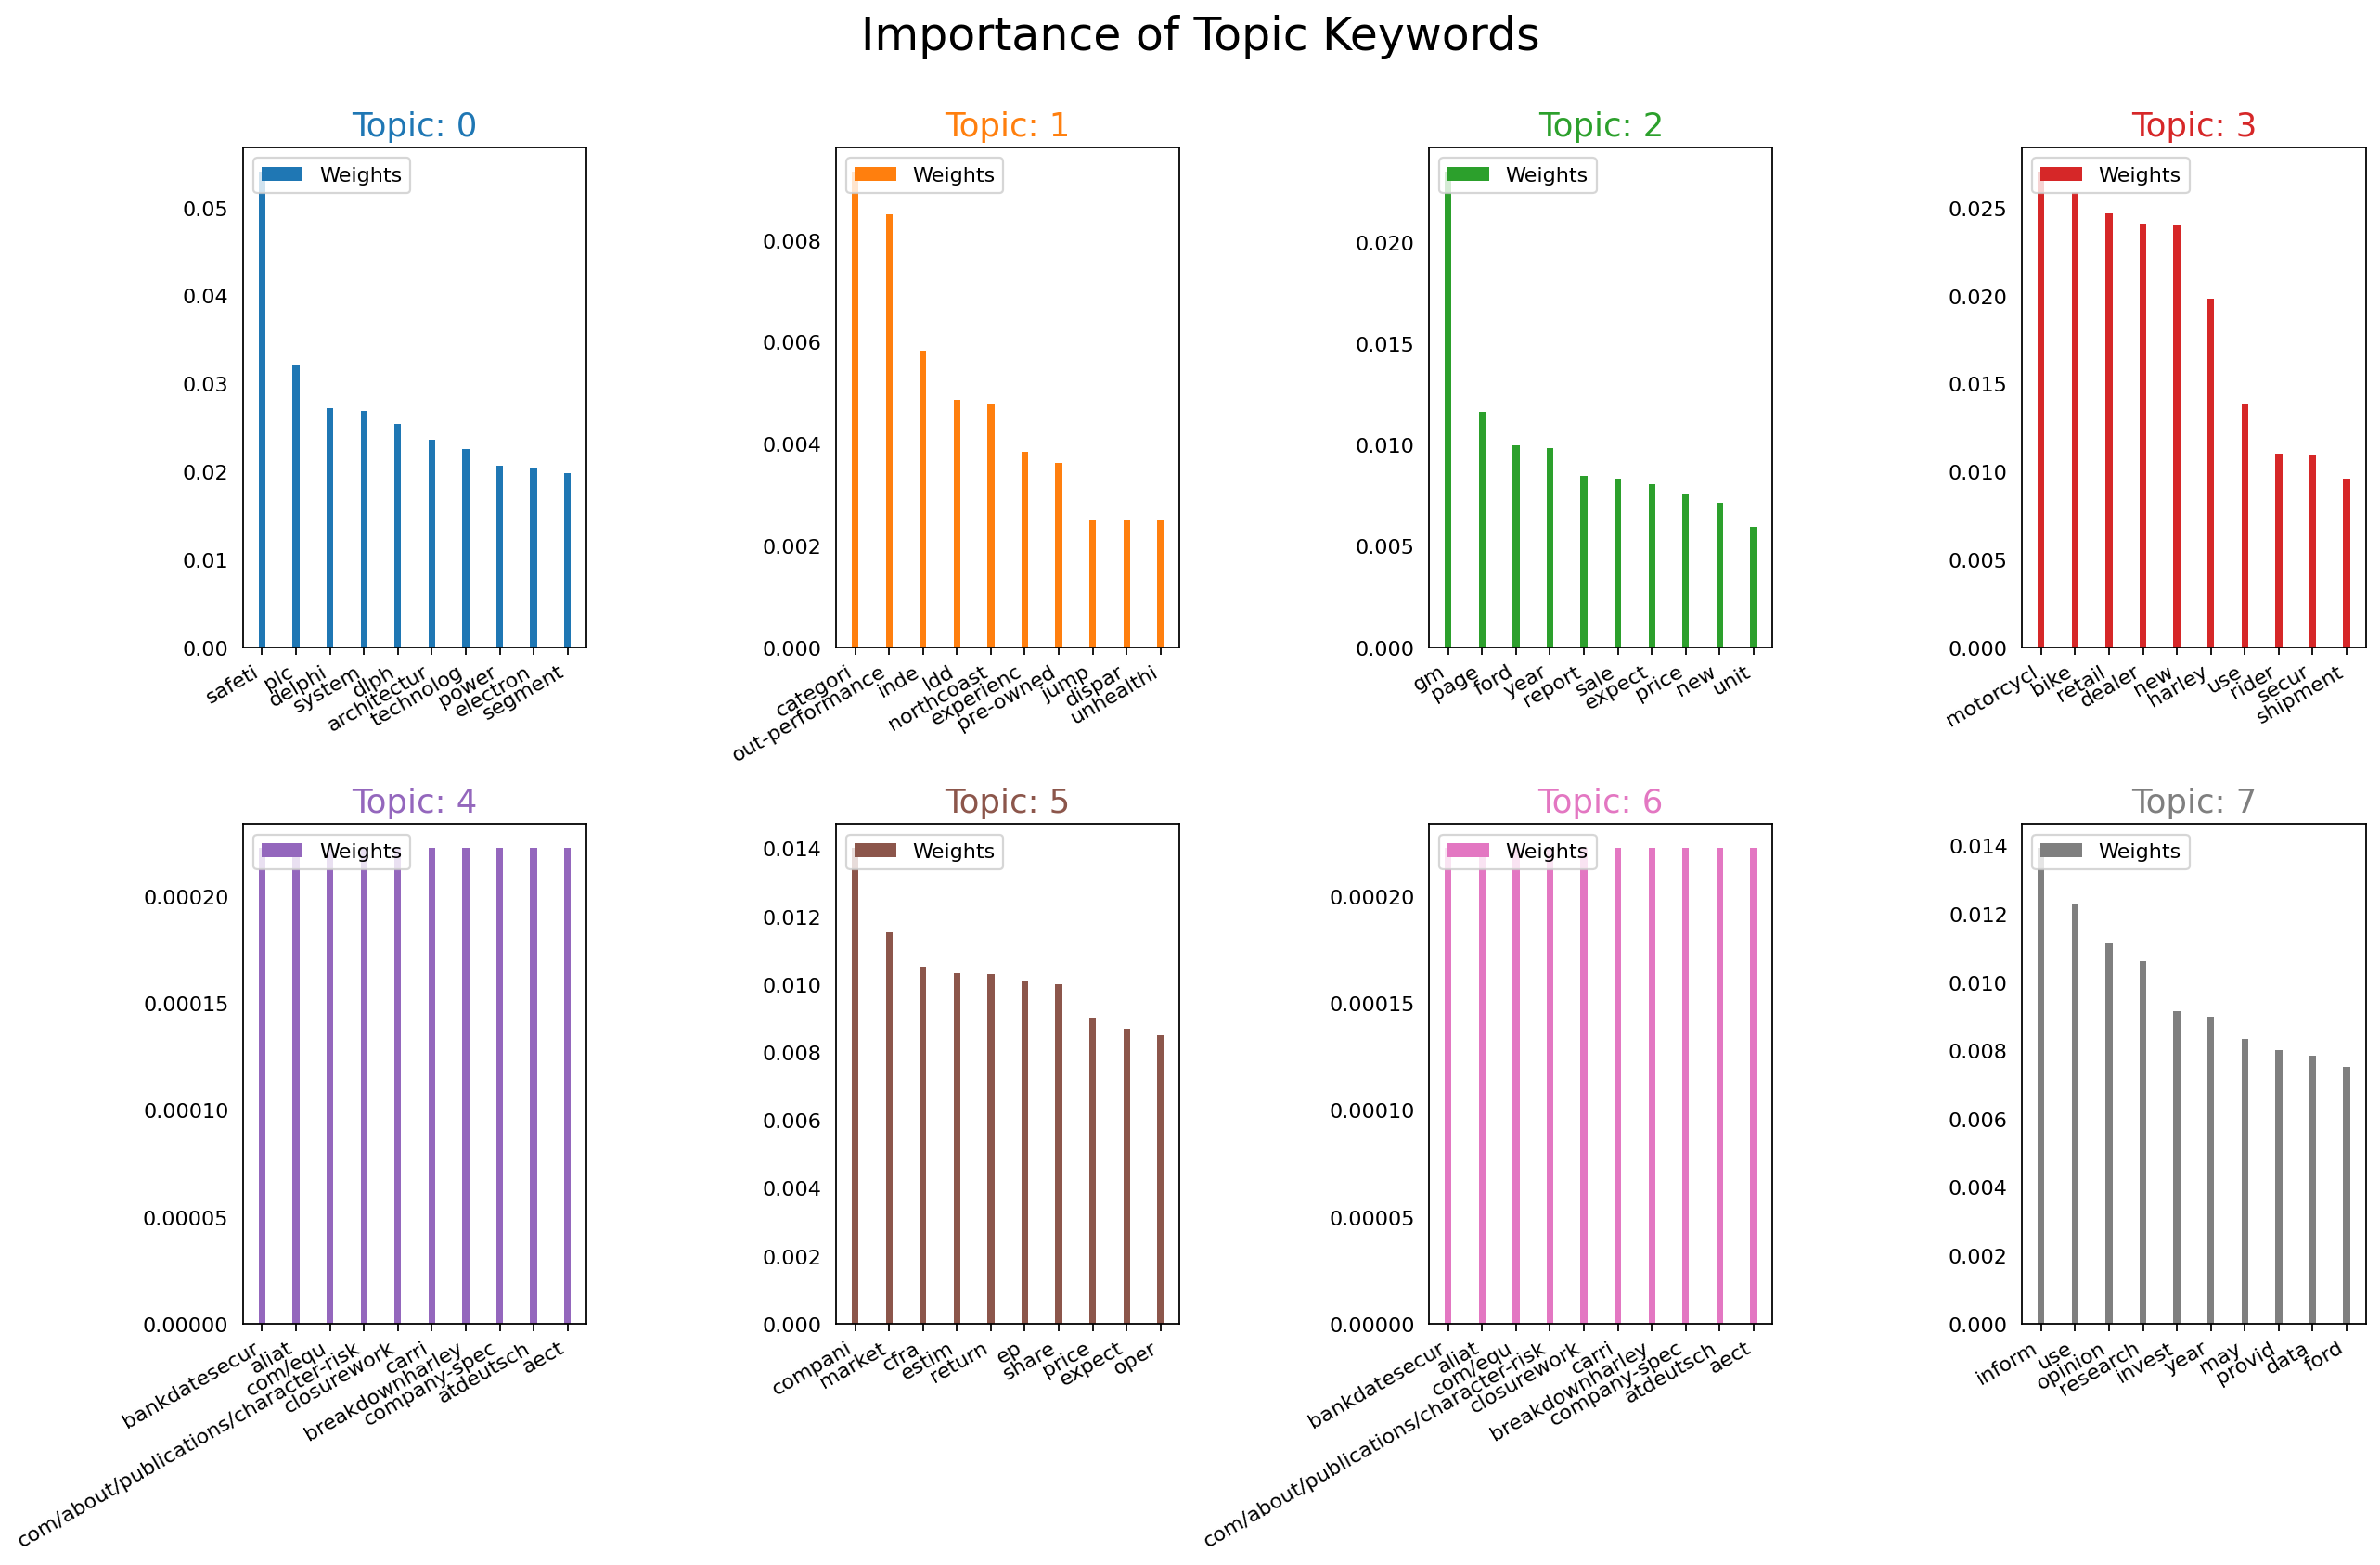

In [88]:
topics=result[0].show_topics(formatted=False)
out = []
for i, topic in topics:
    for word, weight in topic:
        out.append([word, i , weight])

df_topics = pd.DataFrame(out, columns=['word', 'topic_id', 'importance'])

# Plot Word Count and Weights of Topic Keywords
fig, axes = plt.subplots(2, 4, figsize=(16,10), sharey=False, dpi=160)
cols = [color for name, color in mcolors.TABLEAU_COLORS.items()]
for i, ax in enumerate(axes.flatten()):
    ax.bar(x='word', height="importance", data=df_topics.loc[df_topics.topic_id==i, :], 
           color=cols[i], width=0.2, label='Weights')
    #ax.set_ylim(0, 0.01)
    ax.set_title('Topic: ' + str(i), color=cols[i], fontsize=16)
    ax.tick_params(axis='y', left=False)
    ax.set_xticklabels(df_topics.loc[df_topics.topic_id==i, 'word'], rotation=30, horizontalalignment= 'right')
    ax.legend(loc='upper left')
    
fig.tight_layout(w_pad=2)    
fig.suptitle('Importance of Topic Keywords', fontsize=22, y=1.05)    

## Coherence

In [ ]:
coherence_values = []
model_list = []

for num_topics in range(start, limit, step):
        model = gensim.models.wrappers.LdaMallet(mallet_path, corpus=corpus, num_topics=num_topics, id2word=id2word)
        model_list.append(model)
        coherencemodel = CoherenceModel(model=model, texts=texts, dictionary=dictionary, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())

In [77]:
def get_coherence(df, industry, quarter):
    # dictionary: {Key=Industry Code, Value=Index of Report in Metadata}
    industries_to_index = construct_indu_index_mapping(df)

    # dictionary: {Key = Quarter 'YYYY qQ', Value = Index of Report in Metadata}
    quarter_to_index = construct_quar_index_mapping(df)

    # select all report indices (rows in metadata) for the industry-quarter
    indexes = industries_to_index[industry].intersection(quarter_to_index[quarter])
    # set of all company names for the industry-quarter
    all_companies = df.iloc[list(indexes), :].groupby('TICKER')["DCN"].count().reset_index()['TICKER'].tolist()
    # DCN is the unique identification code for the reports

    # subset_companies = ["AAL.OQ", 'ALK.N', 'FDX.N', "DAL.N", "UAL.OQ"]
    dcns = set(df.iloc[list(indexes), :]["DCN"])
    all_files_dcns= get_company_files(dcns)
    # dictionary: {Key=Analyst Name, Value = Index of Report in Metadata}
    analyst_to_index = construct_analyst_index_mapping(df, all_files_dcns)

    ## Estimate LDA model for the entire industry (all companies)
    words = []
    did = 0
    for fname, _ in all_files_dcns:
        f = open(fname, 'r')
        result = f.read()
        tokens = word_tokenize(result)
        tokens = list(filter(("--").__ne__, tokens))
        tokens = list(filter(("fy").__ne__, tokens))
        words.append(tokens)
        did += 1
    # select number of topics
    
    dictionary_LDA = corpora.Dictionary(words)
    corpus = [dictionary_LDA.doc2bow(list_of_tokens) for list_of_tokens in words]
    
    coherence_values = []
    model_list = []
    
    for num_topics in range(1,26,1):
        print(num_topics)

        # generate the LDA Model
        lda_model = models.LdaModel(corpus=corpus,
                                    id2word=dictionary_LDA,
                                    num_topics=num_topics,
                                    random_state=100,
                                    chunksize=10,
                                    passes=100,
                                    alpha='auto',
                                    eta='auto')
        
        model_list.append(lda_model)
        
        coherencemodel = CoherenceModel(model=lda_model, dictionary=dictionary_LDA,
                                        texts=words, coherence='c_v')
        coherence_values.append(coherencemodel.get_coherence())
        
    
    return [model_list,coherence_values]

In [78]:
coh=get_coherence(df2, 2510, '2018 q1')

1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25


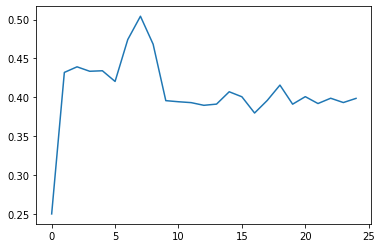

In [81]:
plt.plot(coh[1])

In [82]:
np.argmax(coh[1])

7